In [5]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageNet

import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import os
import time
from utils import AddGaussianNoise, AddSaltPepperNoise
from timm.models import efficientnet_b0
from peff_b0 import PEffN_b0SeparateHP_V1

In [6]:
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn_vision/'
data_root = '/mnt/smb/locker/abbott-locker/hcnn_vision/imagenet/'

# Clean images

In [7]:
clean_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
train_subset_indices = np.random.choice(8000, size=10, replace=False)
train_ds = ImageNet(data_root, split='val', transform=clean_transform)
train_subset = torch.utils.data.Subset(train_ds, train_subset_indices)

In [9]:
loader = torch.utils.data.DataLoader(train_subset, batch_size=1, drop_last=False)
load_iter = iter(loader)

In [10]:
feature, label = next(load_iter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


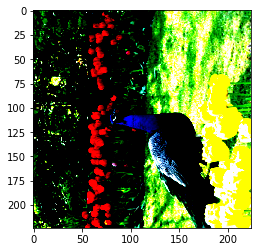

In [52]:
plt.figure()
plt.imshow(
    feature[0].transpose(0,2), interpolation='nearest'
    )
plt.show()

# Gaussian noise images

In [4]:
noise_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    AddGaussianNoise(std=1.50)
])

In [53]:
train_subset_indices = np.random.choice(8000, size=10, replace=False)
train_ds = ImageNet(data_root, split='val', transform=noise_transform)
train_subset = torch.utils.data.Subset(train_ds, train_subset_indices)

In [54]:
loader = torch.utils.data.DataLoader(train_subset, batch_size=1, drop_last=False)
load_iter = iter(loader)

In [57]:
feature, label = next(load_iter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


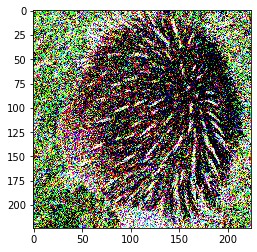

In [58]:
plt.figure()
plt.imshow(
    feature[0].transpose(0,2), interpolation='nearest'
    )
plt.show()

# Elastic Transform

In [59]:
import torchvision.transforms as T

In [153]:
noise_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.ElasticTransform(alpha=250., sigma=4.)
])

In [154]:
train_subset_indices = np.random.choice(8000, size=10, replace=False)
train_ds = ImageNet(data_root, split='val', transform=noise_transform)
train_subset = torch.utils.data.Subset(train_ds, train_subset_indices)

In [155]:
loader = torch.utils.data.DataLoader(train_subset, batch_size=1, drop_last=False)
load_iter = iter(loader)

In [166]:
feature, label = next(load_iter)

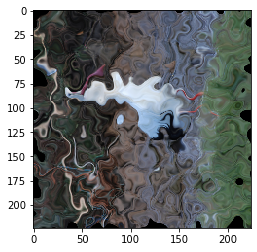

In [167]:
plt.figure()
plt.imshow(
    feature[0].transpose(0,2), interpolation='nearest'
    )
plt.show()

# Fourier Space

In [11]:
feature.shape

torch.Size([1, 3, 224, 224])

In [12]:
x = feature[0]

In [107]:
y = torch.fft.rfft2(feature)

In [110]:
ims.shape

torch.Size([1, 3, 224, 113])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


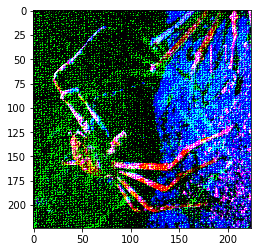

In [119]:
y = torch.fft.rfft2(feature)

res = np.real(y)
ims = np.imag(y)
ims_shape = ims.shape
shuff_indices = np.arange(ims_shape[-1]*ims_shape[-2])
np.random.shuffle(shuff_indices)
for c in [1]:
    c_vals = ims[:,c]
    c_shape = c_vals.shape
    c_vals = c_vals.flatten()
    c_vals = c_vals[shuff_indices]
    ims[:,c] = c_vals.reshape(c_shape)
# for c in [1]:
#     ims_c = ims[:,c]
#     ims_c_shape = ims_c.shape
#     ims_c = ims_c.flatten()
#     np.random.shuffle(ims_c)
#     ims_c = ims_c.reshape(ims_c_shape)
#     ims[:,c] = ims_c

test = res +ims*1j
test = torch.fft.irfft2(test)
plt.figure()
plt.imshow(
    test[0].transpose(0,2), interpolation='nearest'
    )
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


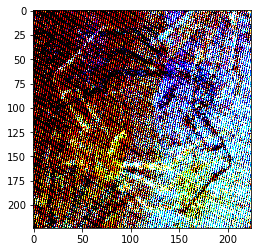

In [116]:
y = torch.fft.rfft2(feature)

res = np.real(y)
ims = np.imag(y)
res_shape = res.shape
shuff_indices = np.arange(res_shape[-1]*res_shape[-2])
np.random.shuffle(shuff_indices)
for c in [0,1,2]:
    c_vals = res[:,c]
    c_shape = c_vals.shape
    c_vals = c_vals.flatten()
    c_vals = c_vals[shuff_indices]
    res[:,c] = c_vals.reshape(c_shape)
# for c in [1]:
#     ims_c = ims[:,c]
#     ims_c_shape = ims_c.shape
#     ims_c = ims_c.flatten()
#     np.random.shuffle(ims_c)
#     ims_c = ims_c.reshape(ims_c_shape)
#     ims[:,c] = ims_c

test = res +ims*1j
test = torch.fft.irfft2(test)
plt.figure()
plt.imshow(
    test[0].transpose(0,2), interpolation='nearest'
    )
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


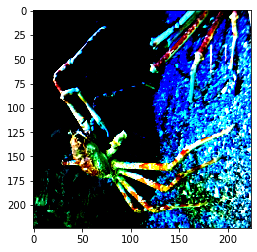

In [32]:
plt.imshow(
    feature[0].transpose(0,2), interpolation='nearest'
    )

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [126]:
class PhaseShuffle(object):
    r"""
    Shuffles phase info of image
    """
    def __init__(self):
        pass
        
    def __call__(self, tensor):
        
        y = torch.fft.rfft2(tensor)

        res = np.real(y)
        ims = np.imag(y)
        ims_shape = ims.shape
        shuff_indices = np.arange(ims_shape[-1]*ims_shape[-2])
        np.random.shuffle(shuff_indices)
        for c in [1]:
            c_vals = ims[c]
            c_shape = c_vals.shape
            c_vals = c_vals.flatten()
            c_vals = c_vals[shuff_indices]
            ims[c] = c_vals.reshape(c_shape)
        new_image = res +ims*1j
        return torch.fft.irfft2(new_image) 
    
    def __repr__(self):
        return self.__class__.__name__ 

In [132]:
class MagShuffle(object):
    r"""
    Shuffles magnitude info of image
    """
    def __init__(self):
        pass
        
    def __call__(self, tensor):
        y = torch.fft.rfft2(tensor)

        res = np.real(y)
        ims = np.imag(y)
        res_shape = res.shape
        shuff_indices = np.arange(res_shape[-1]*res_shape[-2])
        np.random.shuffle(shuff_indices)
        for c in [1]:
            c_vals = res[c]
            c_shape = c_vals.shape
            c_vals = c_vals.flatten()
            c_vals = c_vals[shuff_indices]
            res[c] = c_vals.reshape(c_shape)
        new_image = res +ims*1j
        return torch.fft.irfft2(new_image) 
    
    def __repr__(self):
        return self.__class__.__name__ 

In [133]:
noise_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    MagShuffle()
])

In [134]:
train_subset_indices = np.random.choice(8000, size=10, replace=False)
train_ds = ImageNet(data_root, split='val', transform=noise_transform)
train_subset = torch.utils.data.Subset(train_ds, train_subset_indices)

In [135]:
loader = torch.utils.data.DataLoader(train_subset, batch_size=1, drop_last=False)
load_iter = iter(loader)

In [138]:
feature, label = next(load_iter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


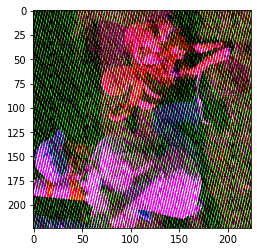

In [139]:
plt.figure()
plt.imshow(
    feature[0].transpose(0,2), interpolation='nearest'
    )
plt.show()